# General functions along with localization - network

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
import tensorflow.keras.backend as K

In [2]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from tensorflow import keras

In [4]:
IMGSIZE = (224, 224 ,3)
OUT_IMG_SIZE = (224 ,224 ,3)

In [6]:
### Localization network architecture ###
def get_Localization_net(trainable = False ,experimental =False):
    """ This is the localization network . It uses VGG16 network , prtrained on Imagenet dataset and it generates  
    parameters for transformations
    Input
    -----
    - Input Layer
    Returns
    -------
    - 3D-Tensor of dimensions (B , 6)
    """
    output_bias = tf.keras.initializers.Constant([1, 0, 0, 0, 1, 0])
    if experimental :
        model = tf.keras.Sequential([
        layers.Conv2D(8, kernel_size=7, input_shape=(IMGSIZE[0], IMGSIZE[1], IMGSIZE[-1]), 
                      activation="relu", kernel_initializer="he_normal"),
        layers.MaxPool2D(strides=2),
        layers.Conv2D(10, kernel_size=5, activation="relu", kernel_initializer="he_normal"),
        layers.MaxPool2D(strides=2),
        layers.Dense(32, activation="relu", kernel_initializer="he_normal"),
        layers.Dense(3 * 2, kernel_initializer="zeros", bias_initializer=output_bias)
        ])
        return model
    vgg = VGG16(include_top =False ,weights ='imagenet' ,input_shape = IMGSIZE )
    vgg.trainable = trainable
    model = tf.keras.Sequential([
       vgg, 
       layers.Flatten(),
       layers.Dense(128 , activation = 'sigmoid',kernel_initializer="glorot_normal"), 
       layers.Dense(64 , activation = 'sigmoid',kernel_initializer="glorot_normal"), 
       layers.Dense(32 , activation = 'sigmoid',kernel_initializer="glorot_normal"),
       layers.Dense(6, kernel_initializer="zeros", bias_initializer=output_bias) 
    ])
    return model

In [7]:
##pixel value generator##
def get_pixel_value(img, x, y):
    """
    Utility function to get pixel value for coordinate
    vectors x and y from a  4D tensor image.
    Input
    -----
    - img: tensor of shape (B, H, W, C)
    - x: flattened tensor of shape (B*H*W,)
    - y: flattened tensor of shape (B*H*W,)
    Returns
    -------
    - output: tensor of shape (B, H, W, C)
    """
    shape = tf.shape(x)
    batch_size = shape[0]
    height = shape[1]
    width = shape[2]

    batch_idx = tf.range(0, batch_size)
    batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1))
    b = tf.tile(batch_idx, (1, height, width))

    indices = tf.stack([b, y, x], 3)

    return tf.gather_nd(img, indices)

In [8]:
## transformation grid generator##
def affine_grid_generator(height, width, theta):
    """
    This function returns a sampling grid, which when
    used with the bilinear sampler on the input feature
    map, will create an output feature map that is an
    affine transformation [1] of the input feature map.
    Input
    -----
    - height: desired height of grid/output. Used
      to downsample or upsample.
    - width: desired width of grid/output. Used
      to downsample or upsample.
    - theta: affine transform matrices of shape (num_batch, 2, 3).
      For each image in the batch, we have 6 theta parameters of
      the form (2x3) that define the affine transformation T.
    Returns
    -------
    - normalized grid (-1, 1) of shape (num_batch, 2, H, W).
      The 2nd dimension has 2 components: (x, y) which are the
      sampling points of the original image for each point in the
      target image.
    Note
    ----
    [1]: the affine transformation allows cropping, translation,
         and isotropic scaling.
    """
    num_batch = tf.shape(theta)[0]

    # create normalized 2D grid
    x = tf.linspace(-1.0, 1.0, width)
    y = tf.linspace(-1.0, 1.0, height)
    x_t, y_t = tf.meshgrid(x, y)

    # flatten
    x_t_flat = tf.reshape(x_t, [-1])
    y_t_flat = tf.reshape(y_t, [-1])

    # reshape to [x_t, y_t , 1] - (homogeneous form)
    ones = tf.ones_like(x_t_flat)
    sampling_grid = tf.stack([x_t_flat, y_t_flat, ones])

    # repeat grid num_batch times
    sampling_grid = tf.expand_dims(sampling_grid, axis=0)
    sampling_grid = tf.tile(sampling_grid, tf.stack([num_batch, 1, 1]))

    # cast to float32 (required for matmul)
    theta = tf.cast(theta, 'float32')
    sampling_grid = tf.cast(sampling_grid, 'float32')

    # transform the sampling grid - batch multiply
    batch_grids = tf.matmul(theta, sampling_grid)
    # batch grid has shape (num_batch, 2, H*W)

    # reshape to (num_batch,2, H, W)
    batch_grids = tf.reshape(batch_grids, [num_batch, 2, height, width])
    #print(batch_grids)
    return batch_grids

In [9]:
def bilinear_sampler(img, x, y):
    """
    Performs bilinear sampling of the input images according to the
    normalized coordinates provided by the sampling grid. Note that
    the sampling is done identically for each channel of the input.
    To test if the function works properly, output image should be
    identical to input image when theta is initialized to identity
    transform.
    Input
    -----
    - img: batch of images in (B, H, W, C) layout.
    - grid: x, y which is the output of affine_grid_generator.
    Returns
    -------
    - out: interpolated images according to grids. Same size as grid.
    """
    H = tf.shape(img)[1]
    W = tf.shape(img)[2]
    max_y = tf.cast(H - 1, 'int32')
    max_x = tf.cast(W - 1, 'int32')
    zero = tf.zeros([], dtype='int32')

    # rescale x and y to [0, W-1/H-1]
    x = tf.cast(x, 'float32')
    y = tf.cast(y, 'float32')
    x = 0.5 * ((x + 1.0) * tf.cast(max_x-1, 'float32'))
    y = 0.5 * ((y + 1.0) * tf.cast(max_y-1, 'float32'))

    # grab 4 nearest corner points for each (x_i, y_i)
    x0 = tf.cast(tf.floor(x), 'int32')
    x1 = x0 + 1
    y0 = tf.cast(tf.floor(y), 'int32')
    y1 = y0 + 1

    # clip to range [0, H-1/W-1] to not violate img boundaries
    x0 = tf.clip_by_value(x0, zero, max_x)
    x1 = tf.clip_by_value(x1, zero, max_x)
    y0 = tf.clip_by_value(y0, zero, max_y)
    y1 = tf.clip_by_value(y1, zero, max_y)

    # get pixel value at corner coords
    Ia = get_pixel_value(img, x0, y0)
    Ib = get_pixel_value(img, x0, y1)
    Ic = get_pixel_value(img, x1, y0)
    Id = get_pixel_value(img, x1, y1)

    # recast as float for delta calculation
    x0 = tf.cast(x0, 'float32')
    x1 = tf.cast(x1, 'float32')
    y0 = tf.cast(y0, 'float32')
    y1 = tf.cast(y1, 'float32')

    # calculate deltas
    wa = (x1-x) * (y1-y)
    wb = (x1-x) * (y-y0)
    wc = (x-x0) * (y1-y)
    wd = (x-x0) * (y-y0)

    # add dimension for addition
    wa = tf.expand_dims(wa, axis=3)
    wb = tf.expand_dims(wb, axis=3)
    wc = tf.expand_dims(wc, axis=3)
    wd = tf.expand_dims(wd, axis=3)

    # compute output
    out = tf.add_n([wa*Ia, wb*Ib, wc*Ic, wd*Id])
    return out

In [10]:
def lambda_function(lst):
    """
    This function is made for keras.layers.Lambda() . This function uses the above utilities get_pixel_value ,
    affine_grid_generator and bilinear_sampler . This function outputs sampled and transformed images as output.
    Input
    -----
    - lst of shape [Input , output of localization net]
    Returns
    -------
    - images of shape (B ,H,W,C)
    
    """
    Input_Layer = lst[0]
    trans_matrix = lst[1]
    trans_matrix = tf.reshape(trans_matrix, (-1, 2, 3))
    grid = affine_grid_generator(OUT_IMG_SIZE[0],OUT_IMG_SIZE[1], trans_matrix)
    x_s = grid[:, 0, :, :]
    y_s = grid[:, 1, :, :]
    x = bilinear_sampler(Input_Layer, x_s, y_s)
    return x

In [11]:
def preprocessing_unit(inp):
    """
    This function is made for keras.layers.Lambda() . This function applies a preprocess for the image to be usable by
    VGG16 network .
    Input
    -----
    - images of shape (B ,H,W,C)
    Returns
    -------
    - preprocess image (4D-Tensor) of same shape (B,H,W,C)
    
    """
    return tf.keras.applications.vgg16.preprocess_input(inp)
    

In [12]:
def color_to_grayscale(inp):
    """
    This function returns grayscale images . It uses the luminosity method 
    given here --- "https://www.johndcook.com/blog/2009/08/24/algorithms-convert-color-grayscale/"
    Input
    -----
    - color images of shape (B ,H,W,C)
    Returns
    -------
    - grayscale images of shape (B ,H,W,C)
    
    """
    x = (0.21 * inp[:,:,:,:1]) + (0.72 * inp[:,:,:,1:2]) + (0.07 * inp[:,:,:,-1:])
    #print(x)
    return tf.tile(x ,(1,1,1,3))

In [13]:
#inp = np.random.normal(size = (1024,120,120,3))
#inp.shape
#color_to_grayscale(inp).shape

In [14]:
def get_STN(inp):
    """
    This the model generator function.
    Input
    -----
    - None
    Returns
    -------
    - intermediate tensorflow.keras.model object (Trainable)
    """
    inp_preprocess = keras.layers.Lambda(preprocessing_unit)(inp)
    trans_matrix = get_Localization_net(trainable = False)(inp_preprocess)
    x = layers.Lambda(lambda_function)([inp , trans_matrix ])
    x = layers.Lambda(color_to_grayscale)(x)
    return x

In [15]:
def get_training_model(use_stn=True , stack = 1):
    """
    Input
    -----
    - None
    Returns
    -------
    - Trainable end model 
    """
    inputs = layers.Input(shape = (IMGSIZE[0], IMGSIZE[0], 3))
    if use_stn:
        for i in range(stack):
            if i == 0:
                outputs = get_STN(inputs)
            else:
                outputs = get_STN(outputs)
    else:
        outputs = inputs
    return tf.keras.Model(inputs, outputs) 

In [16]:
stn_model = get_training_model(stack = 1)

In [17]:
stn_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 6)            17936614    lambda[0][0]                     
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 224, 224, 3)  0           input_1[0][0]                    
                                                                 sequential[0][0]             

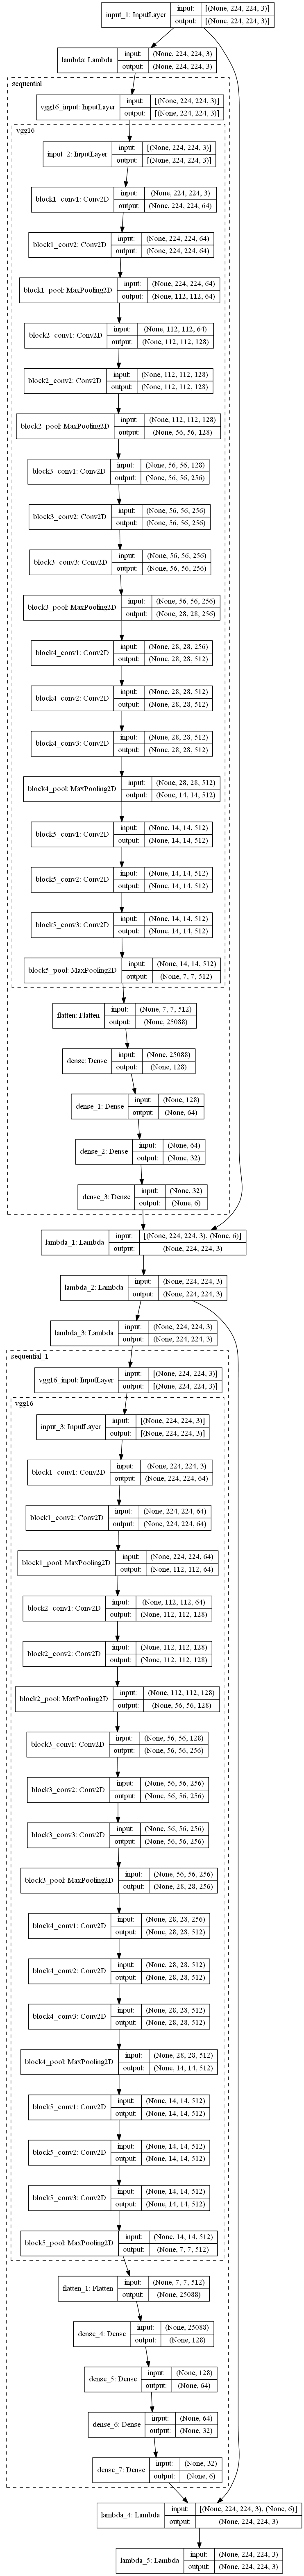

In [18]:
tf.keras.utils.plot_model(stn_model,to_file='Palm_ROI_extractor_model.png' ,show_shapes =True ,expand_nested=True)

In [5]:
import Data_Loader as DL

Code started ...
Code executed successfully


In [6]:
data_loader = DL.data_loader(Base_path = r"D:\BTP\4\IITD_Palmprint_V1")

In [ ]:
data_loader(print_process = False  , in_dim = (IMGSIZE[0],IMGSIZE[1]) ,out_dim = (OUT_IMG_SIZE[0],OUT_IMG_SIZE[1]) )

In [ ]:
X,y,Label,X2,y2,Label2 = data_loader.build_data()

In [ ]:
X,y,Label,X2,y2,Label2 = data_loader.build_data()

In [24]:
X =X.astype('float16') #X.astype('float32')
y = y.astype('float16') # y.astype('float32')

In [25]:
BATCH_SIZE = 8
EPOCHS = 1000

In [26]:
val_samples = 100
x_val, y_val = X[:val_samples], y[:val_samples]
new_x_train, new_y_train = X[val_samples:], y[val_samples:]

train_ds = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((X2, y2)).batch(BATCH_SIZE)

In [27]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=2,mode='auto', baseline=None, restore_best_weights=True)

In [28]:
def cos_mse(y_pred ,y_true):
    return 10*keras.losses.cosine_similarity(y_pred ,y_true) + 0.01*keras.losses.MeanSquaredError()(y_pred ,y_true)

In [29]:
import io
import matplotlib.pyplot as plt
file_writer_cm = tf.summary.create_file_writer("logs/stn_progress")
#stn_mini_model = tf.keras.Model(stn_model.input, stn_model.layers[2].output)
#lst = []
def plot_progress_image(figure):
    buf = io.BytesIO()
    plt.savefig(buf , format = 'png')
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    return image

def log_progression(epoch, logs):
    sampled_transformed = tf.cast(stn_model(X[:1]) , 'uint8')
    #matrix = stn_mini_model(X[:1])
    #lst.append(matrix)
    figure = plt.figure(figsize=(10, 10))
    
    plt.imshow(sampled_transformed[0].numpy().squeeze())
    plt.axis("off")

    progress_image = plot_progress_image(figure)
    with file_writer_cm.as_default():
        tf.summary.image("Progression", progress_image, step=epoch)
        
progress_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_progression)        

In [30]:
scheduler = keras.optimizers.schedules.ExponentialDecay(1e-3, ( 13000 / BATCH_SIZE), 1e-3)
lr = keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

In [31]:
stn_model.compile(loss= 'mse' , optimizer= 'adam', metrics=["mse"]) #tf.keras.optimizers.Adagrad(learning_rate=0.01)
history = stn_model.fit(train_ds, validation_data=val_ds, 
              epochs=EPOCHS, 
               callbacks = [es_callback ,lr,progress_callback],verbose = 1)

Epoch 1/1000

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
150/150 [==============================] - 103s 579ms/step - loss: 3785.3640 - mse: 3785.3665 - val_loss: 3304.7073 - val_mse: 3304.7073
Epoch 2/1000

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009957581, shape=(), dtype=float32).
150/150 [==============================] - 76s 507ms/step - loss: 1819.1967 - mse: 1819.1965 - val_loss: 3223.4194 - val_mse: 3223.4192
Epoch 3/1000

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009915342, shape=(), dtype=float32).
150/150 [==============================] - 76s 506ms/step - loss: 1690.2419 - mse: 1690.2426 - val_loss: 2886.1472 - val_mse: 2886.1472
Epoch 4/1000

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.0009873282, shape=(), dtype=float32).
150/150 [==============================] - 76s 507ms/step - loss: 1700.9225 - mse: 1700.9226 - val_los

150/150 [==============================] - 77s 509ms/step - loss: 1688.8030 - mse: 1688.8029 - val_loss: 3026.9729 - val_mse: 3026.9731
Epoch 33/1000

Epoch 00033: LearningRateScheduler setting learning rate to tf.Tensor(0.0008728168, shape=(), dtype=float32).
150/150 [==============================] - 77s 509ms/step - loss: 1707.7889 - mse: 1707.7891 - val_loss: 2955.7815 - val_mse: 2955.7812
Epoch 34/1000

Epoch 00034: LearningRateScheduler setting learning rate to tf.Tensor(0.00086911436, shape=(), dtype=float32).
150/150 [==============================] - 77s 509ms/step - loss: 1643.2383 - mse: 1643.2374 - val_loss: 2823.3137 - val_mse: 2823.3137
Epoch 35/1000

Epoch 00035: LearningRateScheduler setting learning rate to tf.Tensor(0.0008654277, shape=(), dtype=float32).
150/150 [==============================] - 77s 510ms/step - loss: 1671.4435 - mse: 1671.4430 - val_loss: 2860.8892 - val_mse: 2860.8892
Epoch 36/1000

Epoch 00036: LearningRateScheduler setting learning rate to tf.Te

Epoch 64/1000

Epoch 00064: LearningRateScheduler setting learning rate to tf.Tensor(0.00076505437, shape=(), dtype=float32).
150/150 [==============================] - 77s 510ms/step - loss: 1558.4392 - mse: 1558.4398 - val_loss: 2663.6606 - val_mse: 2663.6611
Epoch 65/1000

Epoch 00065: LearningRateScheduler setting learning rate to tf.Tensor(0.0007618091, shape=(), dtype=float32).
150/150 [==============================] - 77s 510ms/step - loss: 1549.8187 - mse: 1549.8190 - val_loss: 2670.7412 - val_mse: 2670.7415
Epoch 66/1000

Epoch 00066: LearningRateScheduler setting learning rate to tf.Tensor(0.00075857755, shape=(), dtype=float32).
150/150 [==============================] - 77s 511ms/step - loss: 1566.7980 - mse: 1566.7976 - val_loss: 2641.8306 - val_mse: 2641.8306
Epoch 67/1000

Epoch 00067: LearningRateScheduler setting learning rate to tf.Tensor(0.00075535977, shape=(), dtype=float32).
150/150 [==============================] - 77s 511ms/step - loss: 1581.1154 - mse: 1581.1

In [32]:
#tf.keras.models.save_model(stn_model ,'C:/Users/hp/anaconda/Project_files_Palmprint_detector/partial_model_1_step_1')

INFO:tensorflow:Assets written to: C:/Users/hp/anaconda/Project_files_Palmprint_detector/partial_model_1_step_1\assets


In [ ]:
#stn_model = tf.keras.models.load_model('C:/Users/hp/anaconda/Project_files_Palmprint_detector/partial_model' , custom_objects ={'cos_mse' : cos_mse})

In [33]:
stn_model.layers[2].layers[0].trainable


False

In [ ]:
#stn_model.layers[2].layers[0].layers[-6].trainable

In [ ]:
#stn_model.summary()

In [ ]:
# Best --- adagrad(learning_rate = 0.01) ,cos_mse , 100 ep ,out_shape = (200 ,200 ,3)

In [ ]:
#stn_model.compile(loss= cos_mse , optimizer= tf.keras.optimizers.Adagrad(learning_rate=0.004), metrics=["mse"]) #tf.keras.optimizers.Adagrad(learning_rate=0.01)
#stn_model.fit(train_ds, validation_data=val_ds, 
#              epochs=100, 
#               callbacks = [es_callback ,lr],verbose = 1)

In [34]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse', 'lr'])

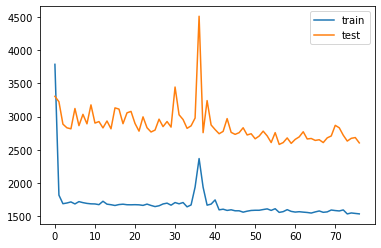

In [35]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper right')

In [38]:
%load_ext tensorboard
%tensorboard --logdir logs/stn_progress

In [36]:
#tf.keras.models.save_model(stn_model ,'C:/Users/hp/anaconda/Project_files_Palmprint_detector/model')


INFO:tensorflow:Assets written to: C:/Users/hp/anaconda/Project_files_Palmprint_detector/model\assets


In [44]:
#loaded_model = tf.keras.models.load_model('C:/Users/hp/anaconda/Project_files_Palmprint_detector/model' , custom_objects ={'cos_mse' : cos_mse}) #'/tmp/model'

In [118]:
#im = stn_model(X2[70][None,:,:,:])

In [34]:
#!kill 19780

'kill' is not recognized as an internal or external command,
operable program or batch file.


In [57]:
#stn_model.layers

In [50]:
im = stn_model(X[51][None,:,:,:])

In [31]:
#im[0].shape

TensorShape([150, 150, 3])

In [51]:
#data_loader.left[1][0].shape

(150, 150, 3)

In [10]:
#X.shape 

(1299, 0, 0, 3)

In [33]:
#im[0].shape

TensorShape([150, 150, 3])

In [34]:
#y[0].shape

(150, 150, 3)

In [33]:
#im[0].shape

TensorShape([150, 150, 3])

In [51]:
tf.keras.preprocessing.image.array_to_img(im[0]).show()

In [93]:
#X2 =X2.astype('float16') #X.astype('float32')
#y2 = y2.astype('float16') # y.astype('float32')

In [94]:
#test_ds = tf.data.Dataset.from_tensor_slices((X2, y2)).batch(BATCH_SIZE)

In [95]:
#stn_model.evaluate(test_ds)

57/57 [==============================] - 16s 270ms/step - loss: 15.3454 - mse: 2534.4133


[15.3454008102417, 2534.413330078125]

In [96]:
#stn_model.evaluate(train_ds)

75/75 [==============================] - 21s 270ms/step - loss: 4.1119 - mse: 1411.1117


[4.111946105957031, 1411.1116943359375]

Further testing code

In [16]:
#import cv2
#img1 = cv2.imread(r'D:\BTP\0b2dae8928e178f368b6d152a1367b7f--cats-meowing-kitty-cats.jpg')
#cv2.imshow('img' ,img1)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
#img_copy = np.copy([img1])
#img_copy
#img_preprocessed = cv2.resize(img_copy.astype('uint8'), (224, 224))
#img_preprocessed = tf.keras.applications.vgg16.preprocess_input(img_preprocessed)
#img_preprocessed
#img_out = stn_model(img_preprocessed)

In [17]:
# example of loading the inception v3 model
#from tensorflow.keras.applications.inception_v3 import InceptionV3
# load model
#model = InceptionV3()
# summarize the model
#model.summary()

In [1]:
#from tensorflow.keras.preprocessing.image import load_img
#from tensorflow.keras.preprocessing.image import img_to_array

In [2]:
#image = load_img(r'D:\BTP\4\IITD_Palmprint_V1\Segmented\Left\001_1.bmp', target_size=(150, 150))
#image = img_to_array(image)

In [5]:
#image.shape

(150, 150, 3)

In [21]:
#new_image = stn_model(image[None,:,:,:])

In [8]:
#import tensorflow as tf

In [9]:
#tf.keras.preprocessing.image.array_to_img(image).show()

In [23]:
#tf.keras.preprocessing.image.array_to_img(image).show()